# Style Transfer with  a VGG-11 network
### Basic principles of style transfer
In this notebook we implement a style transfer method, which is originally described in the paper [Image Style Transfer Using Convolutional Neural Networks, by Gatys, Ecker and Bethge](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). Please  have a look into this document in order to get some initial understanding. 

<img src='style_transfer.PNG' width=80% />

Our target is to "transfer" the optical **style** of one image to another image by preserving the **content** of the original image. How to do that with a neural network? 

The basic idea is to feed a CNN (convolutional neural network) with images and to **extract** the style and content somehow. So the next question is, where the style and the content are to be found inside the network?

Let's first have a short look how the human brain (visual cortex, etc.) would process some optical information step by step: First of all (when some photons are recepted in the eye) the information would be very basic - e.g. "something red seen in the lower left corner". Then this information gets refined while flowing through the neurons: "something red seen, which has a round shape". Then - at some point - we would get the information: "a ball seen". If we look at this facts under the aspect of **style** and **content** we see something clearly: 

* **style** (color, texture, etc.) is more located in the earlier layers of the neural network (both human brains and artificial CNNs) - e.g. the usage of the color red 
* **content** is more located in the deeper layers of the neural network - e.g. recognizing special objects (persons, cars, etc. - or a ball in our case)

These insights are technically used for the **style transfer** via CNNs as follows:

* The **style image** is send through the CNN in order to get the style information out of the earlier layers
* The **content image** is send through the CNN in order to get the content information out of the deeper layers

Next question is: How to transfer the style into the target image? We will start off with the target image as being a copy of the content image and "**inject the style**" with backpropagation step by step. However - there is one difference as with "normal backpropagation" of neural networks: Normally the loss is computed based on the final output of the network and the weights are adjusted inside the network. With style transfer the situation is different:

* The **style loss** is computed at the **style layers** (early in the network)
* The **content loss** is computed at the **content layers** (deeper in the network)
* **Backpropagation** does not affect the weights inside the network, but the **target image** being the input of network. (In our case it is better to regard the target image as the **very first layer** of the network.)

<img src='style_injection.PNG' width=60% />

### Network selection
In this notebook we are using the VGG-11 network for implementation (in contrast to the VGG-19 network, which was proposed in the original paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) Feel free to use other (more complex but also slower) networks, if you are a little bit familiar with style transfer. When using other VGG networks there should only be minor changes.

### Technical Preconditions
There are the following basic preconditions for running this notebook:
* Pytorch has to be installed (see https://pytorch.org/  for the installation notes)
* The usage of a GPU is highly recommened. (For small images also a CPU "might do it")   

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

### Get the pre-trained VGG-11 model

Pytorch offers __[pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html)__, from which we will use the VGG-11 model. If a GPU is available (which should be the case) the model is transferred  to the GPU.
The pre-trained VGG-11 model is frozen next (as mentioned before) because we will only manipulate the resulting target image.

In [2]:
# check for GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# get the pre-trained VGG-11 model (only the feature part is relevant for us - not the classifier part)
vgg = models.vgg11(pretrained=True).features 

# freeze all model parameters (because only the resulting target image will be manipulated)
vgg.requires_grad_(False)
vgg.to(device)    

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU(inplace=True)
  (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU(inplace=True)
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=

### Load content and style images

Next a content and a style image are loaded. Feel free to choose your own images. (Later we will be using a copy of the content image as a starting point to "inject" the style.)

We have choosen an image length of 400 - but huger images are no problem (as long as a GPU is available). 
The following methods `load_image()` and `image_convert()` are for bringing the content and target image to the same size and also for converting images from one format to another:

* Image (as on the file system) <=> Image (numpy format) <=> Image (Pytorch-specific tensor format)

In [4]:
def load_image(img_path, max_size=400, shape=None):
    '''Convert the image file to tensor format and resize it
    
    :param  :img_path Local file path 
    :param  :max_size Maximal pixel size for small side of the image
    :param  :shape    Pixel height and width
    :return           Tensor appropriate for network input
    '''

    image = Image.open(img_path).convert('RGB') 
    
    # set size according to input parameters
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
        
    # resize and normalize so the image fits to the original training data of the VGG network 
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

    # drop the transparency channel
    image = in_transform(image)[:3,:,:]
    
    # add an additional batch dimension
    image = image.unsqueeze(0)
    
    return image

In [5]:
# local file names
content_file_path = 'rabbit.jpg'
style_file_path   = 'pattern.jpg'

# Maximum pixel size (small side of the image)
max_size          = 400

# load content and style image with same size
# hint: for the content image the ratio is kept, for the style image it is not kept
content_image = load_image(content_file_path, max_size=max_size).to(device)
style_image   = load_image(style_file_path, shape=content_image.shape[-2:]).to(device)

In [6]:
def image_convert(tensor):
    """Convert the tensor to an image, which can be plotted 
    
    param: tensor: Image in tensor format
    return:        Image in numpy format, so it can be plotted
    """
    
    image = tensor.to("cpu").clone().detach()
    
    # Remove batch dimension first
    image = image.numpy().squeeze() 
    
    # Swap dimension (height and with) with color channel 
    image = image.transpose(1,2,0) 
    
    # Denormalize (= revert previous normalization)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) 
    
    # Make sure pixel values are not out of range
    image = image.clip(0, 1)

    return image

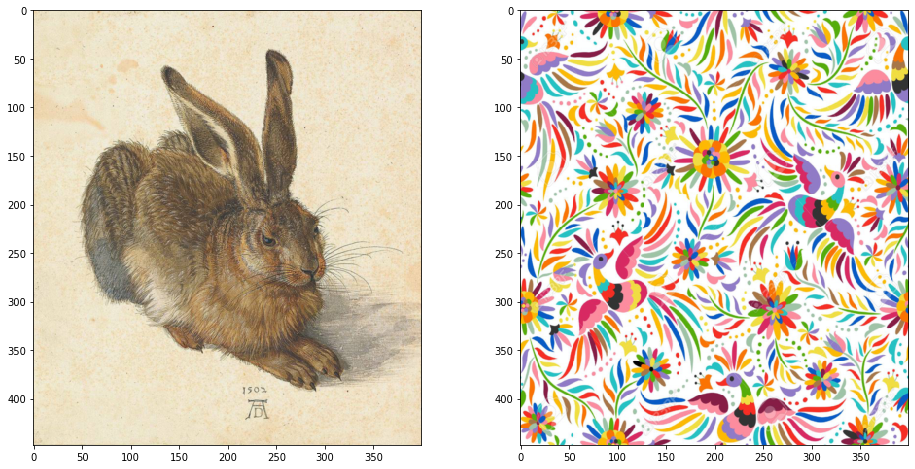

In [7]:
# display both the content and the style image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(image_convert(content_image))
ax2.imshow(image_convert(style_image))

## Content and style features
The function `get_features()` gets us the features - both style and content features - of an image at all layers, which we are interested in. This is done by sending any image through all layers of the network at collecting "feature snapshots" of certain layers (style or content relevant layers).

In [8]:
def get_features(image, model):
    """ Send an image forward through a model and get the features for special layers
    
    param: image: The image, which is send through the network
    param: model: The neural network 
    return:       A dictionary consisting of layer names and the associated features 
    """
    
    # all content and style layers of the network, which we are interested in
    layers = {'0' : 'conv1_1',
              '3' : 'conv2_1', 
              '6':  'conv3_1', 
              '11': 'conv4_1',
              '13': 'conv4_2',  
              '16': 'conv5_1'}
        
    # features (= output of the layers, which we are interested in)
    features = {}
    
    # send the image through the network - layer by layer
    # collect the layer output (= features) for the special layers we are interested in
    im       = image
    for name, layer in model._modules.items():

        im = layer(im)   
        if name in layers:
            features[layers[name]] = im                  
            
    return features

### Gram matrix 
Now that we can extract the features via `get_features()` we still havn't got the "style itself" or some numbers describing the style "in some concise way". That's were the __[gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix)__ comes into play.

The basic idea is to **set each feature in relation to each other**. If we had 16 features, the gram matrix would be 16x16. The gram matrix tells us, how each combination of two features is **correlated** to each other. The correlation is computed as the scalar product of the two features (which we have flattened before to get rid of their spatial dimensions). The idea of correlations is best described by a (simplified) example:

Let's say *feature 1* measures the occurrence of the color green and *feature 2* measures the occurence of diagonal lines, then a high value of *scalar product (feature 1, feature 2)* would indicate a lot of diagonal green lines, a very low value no diagonal green lines.

The function `gram_matrix()` given us the gram matrix for some special layer.

In [9]:
def gram_matrix(tensor):
    """ Calculate the gram matrix  
        see https://en.wikipedia.org/wiki/Gramian_matrix for more details
        
        param: tensor: Feature tensor for special CNN layer
        return:        Gram matrix
    """
    
    # flatten each feature of the convolutional layer 
    flattened_tensor = tensor.flatten(start_dim=2).squeeze()
    
    # compute the gram matrix, which contains the interim relations (scalar-products) of the features of a layer
    gram = flattened_tensor.matmul(flattened_tensor.T)
    
    return gram 

### Get the initial content and style features
Because we will need the initial content and style features over and over again during the loss computations, we are getting them once beforehand.

In [10]:
# get the initial content and style features (before computing the target image)
content_features = get_features(content_image, vgg)              
style_features   = get_features(style_image, vgg)                

# calculate the gram matrices for each style-relevant layer 
style_gram = {layer: gram_matrix(style_features[layer]) for layer in style_features}

### Initialize the resulting target image
For the resulting target image we start off with a copy of the content image. This image will be augmented with the style of the style image step by step. For the (style) optimization we are using an Adam optimizer.

In [11]:
# create an initial result image - as a copy of the content image - and make it changable
result_image = content_image.clone().requires_grad_(True).to(device)   

# tell the optimizer, that we are only interested in changing the result image
lr = lr=0.003
optimizer = optim.Adam([result_image], lr=lr)

### Define loss functions

#### Total loss

The loss consists **both** of the **style** and the **content** loss, which means:
* The **content** of the original content image should be preserved as good as possible
* The **style** of the original style image should be "injected" as much as possible

These two types of loss have to be balanced out by appropriate weights.

#### Content loss
The content loss is computed based on the features of the "content layer" - as a "delta" of the original content image and the currently computed target image.

Hint: In this implementation we are only using one content layer (not many).

#### Style loss

For the style loss the situation is a bit more complicated, because there are many "style layers". Again we have to balance out - but now it is balancing out the weights between the different style layers: Do we favor more "basic styles" - e.g. colors - or do we favor more "sophisticated styles" (pattern, textures, etc.)? This decision has to be taken. In the implementation below it is some mixture. Feel free to change the values.

The style loss is finally computed based on the features of the "style layers" - as a "delta" of the original style image and the currently computed target image. For the individual style layers we need to use a gram matrix each, to get hold of some numerical values, which describe the style.

In [12]:
def get_style_loss(result_features):
    """Get the style loss
    
    param: :result_features Features of the current computation of the result image
    return:                 Style loss
    """
    
    # weights for each style relevant layer 
    # prefering earlier layers will result in more basic style artifacts (e.g. colouring)
    # prefering later layers will result in more sophisticated style artifacts (e.g. special textures)
    style_weights = {'conv1_1': 1.,
                     'conv2_1': 0.8,
                     'conv3_1': 0.5,
                     'conv4_1': 0.3,
                     'conv5_1': 0.2}    

    # iterate through each style layer and add up the style loss
    style_loss = 0
    for layer in style_weights:   
        
        # get the style features of the result and the original style image
        result_feature = result_features[layer] 
        style_feature  = style_features[layer]
        _, dim, height, width = result_feature.shape
        
        # Calculate the gram matrices
        result_gram = gram_matrix(result_feature)                                #                     
        style_gram  = gram_matrix(style_feature)     
        
        # Calculate the style loss 
        layer_style_loss = torch.mean((result_gram - style_gram)**2)
        
        # add up the style loss
        style_loss += layer_style_loss / (dim * height * width)    
    
    return style_loss
    
def get_content_loss(result_features): 
    """Get the content loss
    
    param: :result_features Features of the current computation of the result image
    return:                 Content loss
    """
    
    # Select the layer relevant for the content
    content_layer = 'conv4_2'
    
    # Calculate the content loss
    content_loss = torch.mean((result_features[content_layer] - content_features[content_layer])**2)
    
    return content_loss
    
def get_total_loss(result_features):  
    """Get the total loss
    
    param: :result_features Features of the current computation of the result image
    return:                 Total loss (= weighted content and style loss)
    """
    
    # relative weights of content and style 
    content_weight = 1  
    style_weight = 1e6  
    
    content_loss = get_content_loss(result_features)
    style_loss   = get_style_loss(result_features)
    
    return content_weight * content_loss + style_weight * style_loss    

### Run the image computation
Generating the resulting image - which is a fusion of style and  content - is straight forward. Decide about the iterations. A value of 6000 has proven to be sufficient in most cases. The interim result will be shown every 400 iterations, so you can directly watch the fusion.

Total loss:  266705904.0


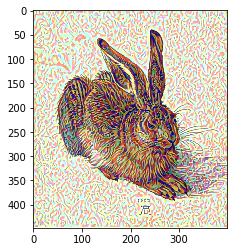

Total loss:  93823224.0


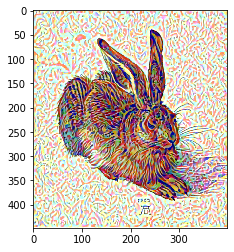

Total loss:  48171324.0


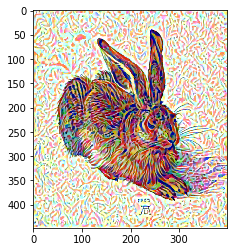

Total loss:  28453550.0


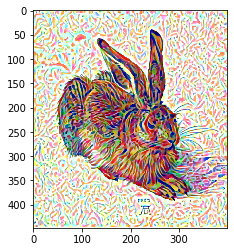

Total loss:  18284556.0


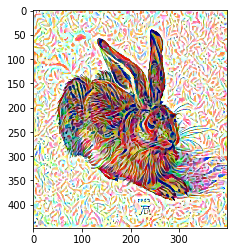

Total loss:  12542082.0


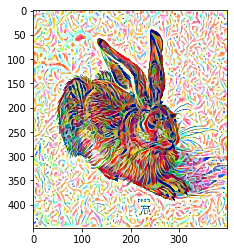

Total loss:  9071176.0


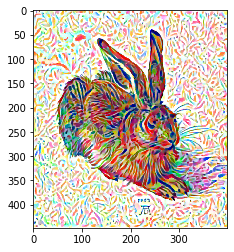

Total loss:  6824528.0


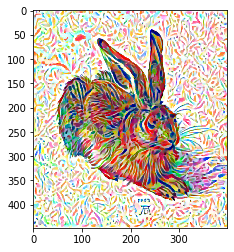

Total loss:  5286299.5


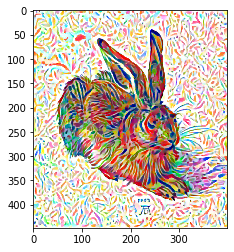

Total loss:  4180991.5


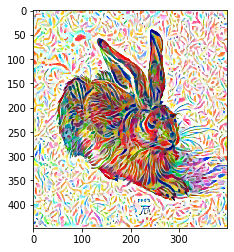

Total loss:  3359145.75


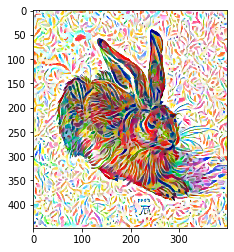

Total loss:  2734505.0


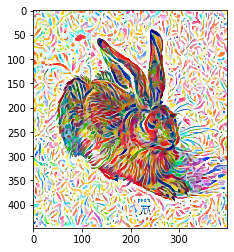

Total loss:  2251667.0


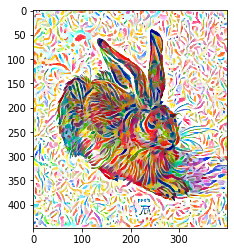

Total loss:  1873760.0


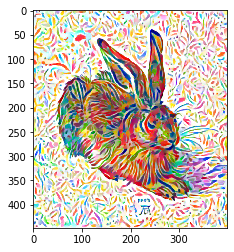

Total loss:  1573953.375


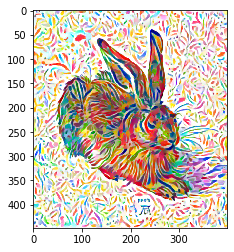

In [13]:
# iteration hyper parameters
show_every = 400
iterations = 6000  

for ii in range(1, iterations+1):
    
    # get the features of the current computation
    result_features = get_features(result_image, vgg)
    
    # compute the total loss (regarding both content and style)
    total_loss   = get_total_loss(result_features)
    
    # update your result image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()                                       
    
    # display intermediate images and print out the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(image_convert(result_image))
        plt.show()

### Display the resulting image
Display the final result and (optionally) save as file.

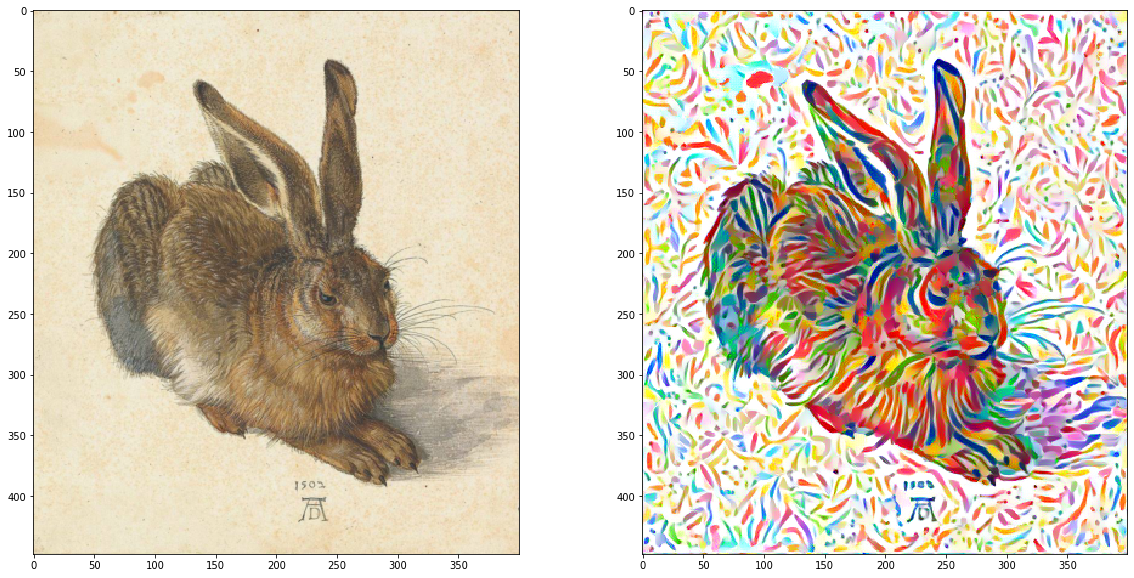

In [14]:
# display the content and resulting image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image_convert(content_image))
ax2.imshow(image_convert(result_image))

In [15]:
# save image to the local file system
result_file_path = 'result1.jpg'
matplotlib.image.imsave(result_file_path, image_convert(result_image))